In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/ATML-PA-2/Baseline

/content/drive/MyDrive/ATML-PA-2/Baseline


In [ ]:
from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()

classes = os.listdir(f"{root_dir}/Art")


In [ ]:
print(device)

cuda


In [ ]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):

    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x

    import types
    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    train_workflow(truncated_model, cache_source, cache_target, config, device)
    evaluate_ds(cache_target, truncated_model, device, target[0], None)

    latents_s, labels_s = get_features(truncated_model[:-1], cache_source, batchsize=32, device=device)
    latents_t, labels_t = get_features(truncated_model[:-1], cache_target, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [ ]:
model = resnet_classifier(num_classes=len(classes))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [ ]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [ ]:
cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3:  25%|██▌       | 88/351 [07:01<52:42, 12.02s/it]

Training:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1/2

Train loss: 3.85203 |  Train acc: 12.46 %

Test loss: 2.07975 | Test acc: 68.97 %



Training:  50%|█████     | 1/2 [00:19<00:19, 20.00s/it]


Epoch 2/2

Train loss: 2.36061 |  Train acc: 58.01 %

Test loss: 0.77848 | Test acc: 86.21 %



Training: 100%|██████████| 2/2 [00:38<00:00, 19.49s/it]
c:\Users\shaya\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\shaya\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
c:\Users\shaya\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\shaya\anaco


=== Evaluation for Clipart Domain ===
Accuracy: 86.21%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           4     1.0000    1.0000    1.0000         1
           6     1.0000    1.0000    1.0000         1
          12     1.0000    1.0000    1.0000         1
          13     1.0000    1.0000    1.0000         1
          22     1.0000    1.0000    1.0000         1
          26     0.0000    0.0000    0.0000         0
          28     1.0000    1.0000    1.0000         2
          29     1.0000    1.0000    1.0000         1
          31     1.0000    1.0000    1.0000         2
          32     1.0000    1.0000    1.0000         1
          34     0.0000    0.0000    0.0000         1
          42     0.0000    0.0000    0.0000         1
          47     0.6667    1.0000    0.8000         2
          50     1.0000    1.0000    1.0000         2
          51     0.0000    0.0000   

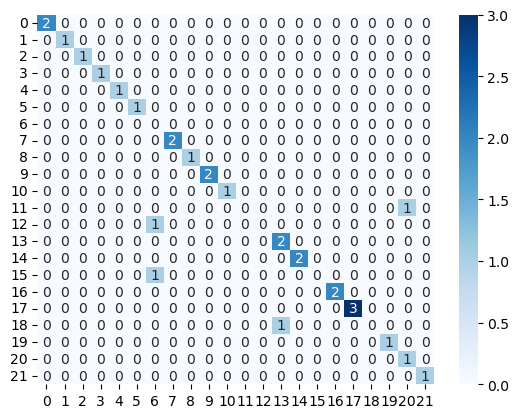

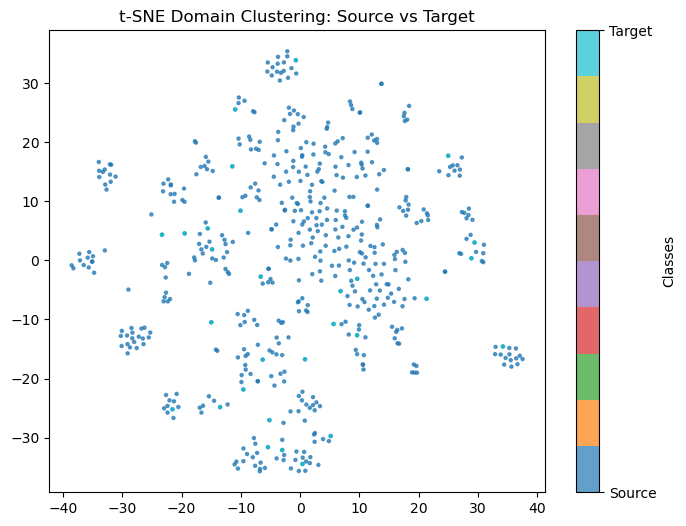

In [ ]:
config = {'epochs':2, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-5}
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)